
--- Loading the trained model from 'univariate_lstm_model_base_model.keras' ---


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                        │ (None, 180, 32)             │           4,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 180, 32)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_5 (LSTM)                        │ (None, 32)                  │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 39,653 (154.90 KB)

 Trainable params: 13,217 (51.63 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 26,436 (103.27 KB)


Evaluating the loaded model on the test set...
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 189ms/step
Root Mean Squared Error (RMSE): 0.0245
Mean Absolute Error (MAE): 0.0182


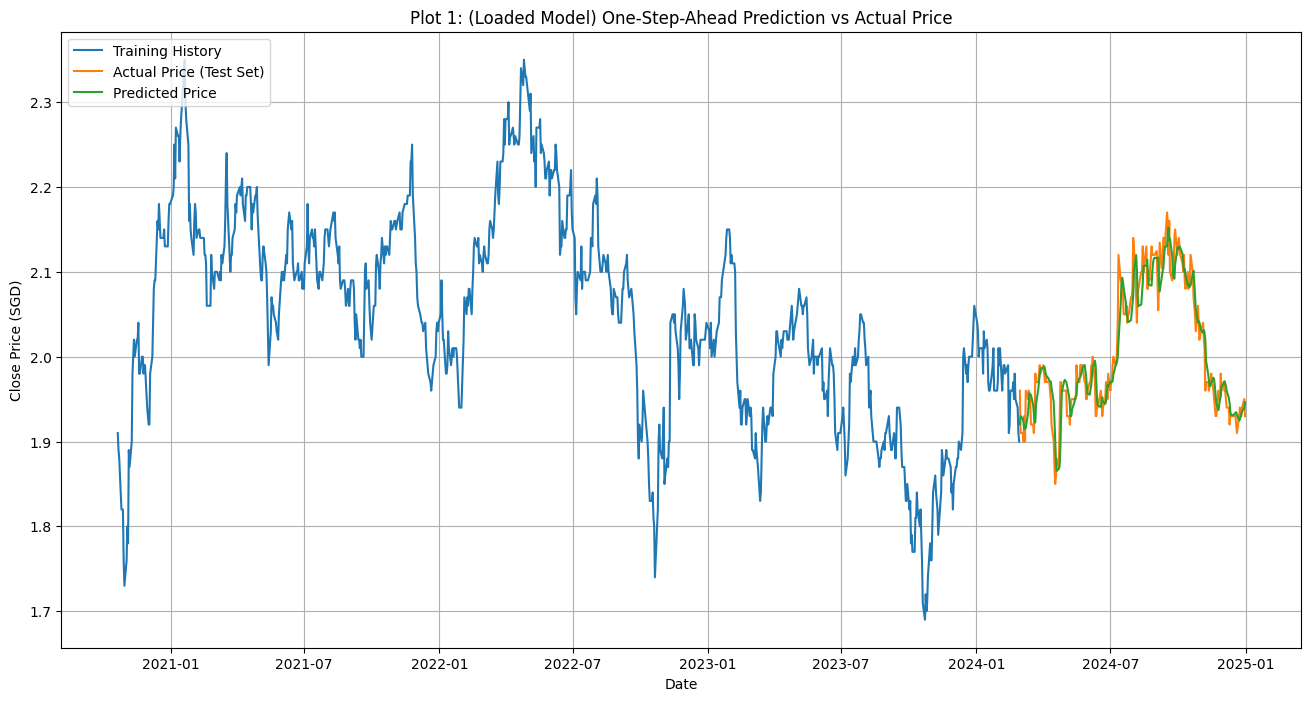


--- Starting 90-day forecast backtest with loaded model ---


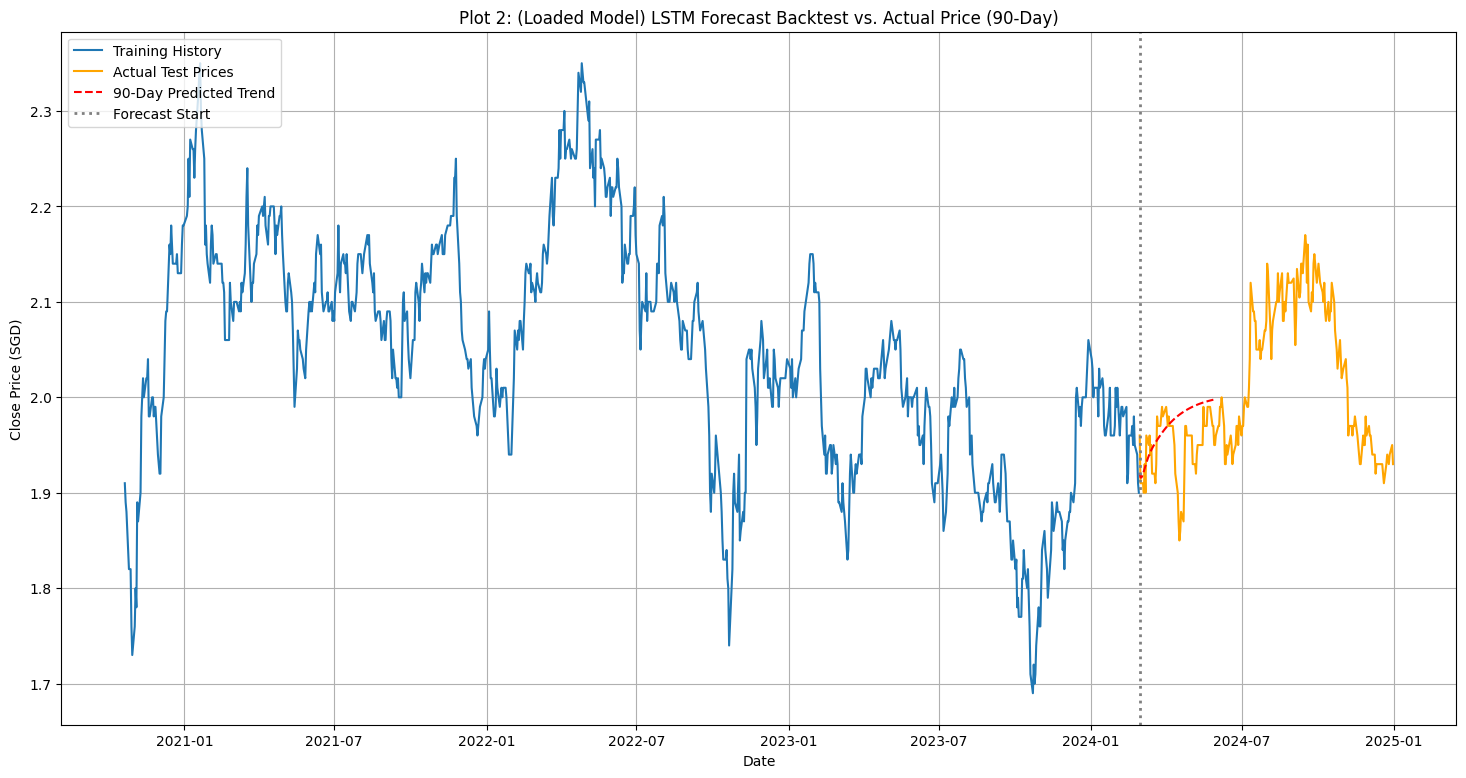


--- Starting Iterative Forecasting for 90 days into the future with loaded model ---


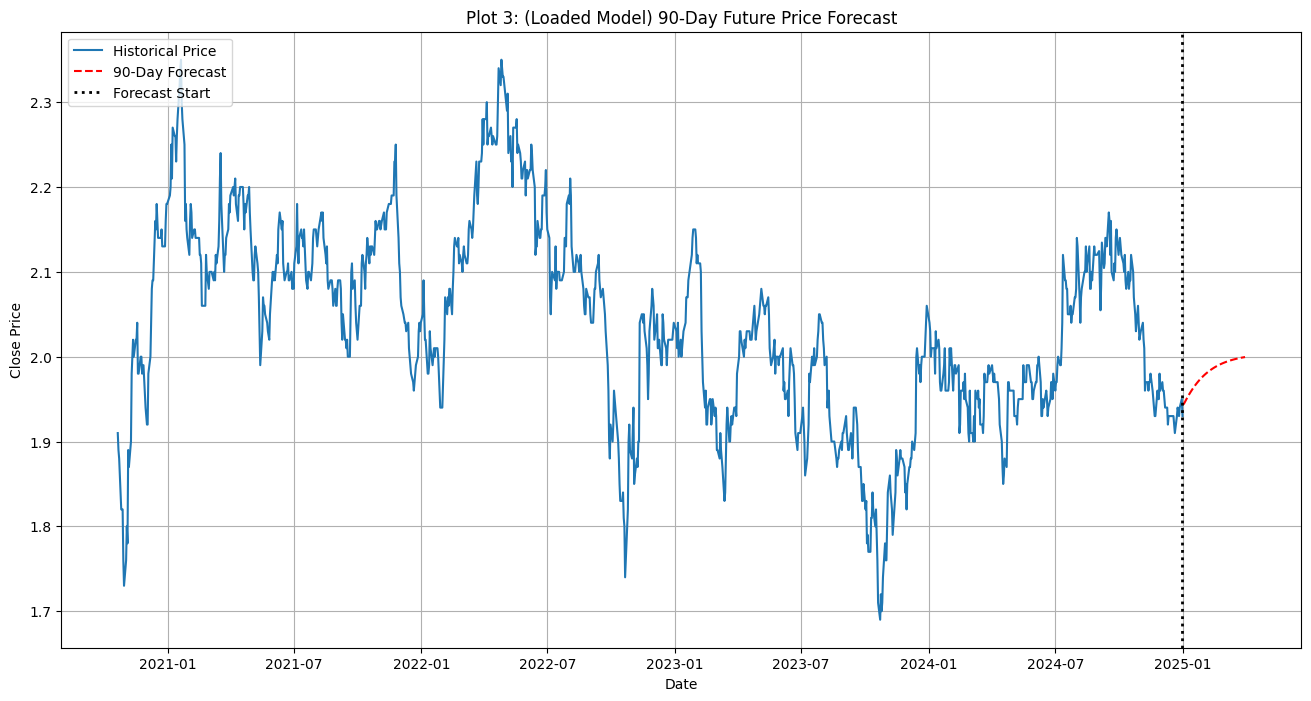

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import load_model # 

# --- 1. Load and Prepare Data ---
try:
    df = pd.read_csv('calculated_averages/C38U.SI_stock_price_history_with_indicators.csv', parse_dates=['Date'], index_col='Date')
except FileNotFoundError:
    print("Error: CSV file not found. Please check that the file path is correct.")
    exit()

data = df.filter(['Close'])
dataset = data.values

# Create and fit the scaler
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

# --- 2. Load the Pre-trained Model ---
# This replaces the 'Build Model' and 'Train Model' sections
try:
    print("\n--- Loading the trained model from 'univariate_lstm_model_base_model.keras' ---")
    model = load_model('univariate_lstm_model_base_model.keras')
    model.summary()
except OSError:
    print("Error: Model file 'univariate_lstm_model_base_model.keras' not found. Please run the training script first.")
    exit()


# --- THE REST OF THE SCRIPT FOR EVALUATION AND FORECASTING IS THE SAME ---

# --- Define constants needed for the script ---
SEQ_LEN = 180
train_data_len = int(np.ceil(len(dataset) * .8))


# --------------------------------------------------------------------------------------
# --- PART A: ONE-STEP-AHEAD EVALUATION ON TEST SET ---
# --------------------------------------------------------------------------------------

# --- 3. Create the Testing Data Set ---
test_data = scaled_data[train_data_len - SEQ_LEN:, :]
x_test = []
y_test = dataset[train_data_len:, :]

for i in range(SEQ_LEN, len(test_data)):
    x_test.append(test_data[i-SEQ_LEN:i, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))

# --- 4. Get the Model's Predicted Price Values ---
print("\nEvaluating the loaded model on the test set...")
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

# --- 5. Evaluate Model Performance ---
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print(f'Root Mean Squared Error (RMSE): {rmse:.4f}')
mae = mean_absolute_error(y_test, predictions)
print(f'Mean Absolute Error (MAE): {mae:.4f}')

# --- 6. Visualize the Test Set Predictions ---
train_plot_data = data[:train_data_len]
valid_plot_data = data[train_data_len:].copy()
valid_plot_data['Predictions'] = predictions

plt.figure(figsize=(16,8))
plt.title('Plot 1: (Loaded Model) One-Step-Ahead Prediction vs Actual Price')
plt.xlabel('Date')
plt.ylabel('Close Price (SGD)')
plt.plot(train_plot_data['Close'], label='Training History')
plt.plot(valid_plot_data['Close'], label='Actual Price (Test Set)')
plt.plot(valid_plot_data['Predictions'], label='Predicted Price')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()


# --------------------------------------------------------------------------------------
# --- PART B: 90-DAY FORECAST BACKTEST ---
# --------------------------------------------------------------------------------------

# --- 7. Perform Iterative Forecasting for Backtest ---
N_STEPS_BACKTEST = 90
print(f"\n--- Starting {N_STEPS_BACKTEST}-day forecast backtest with loaded model ---")

initial_sequence_backtest = scaled_data[train_data_len - SEQ_LEN : train_data_len, :]
current_input_backtest = initial_sequence_backtest.reshape(1, SEQ_LEN, 1)
backtest_predictions_scaled = []

for i in range(N_STEPS_BACKTEST):
    next_prediction_scaled = model.predict(current_input_backtest, verbose=0)[0, 0]
    backtest_predictions_scaled.append(next_prediction_scaled)
    
    new_input_list = current_input_backtest[0, :, 0].tolist()
    new_input_list.pop(0)
    new_input_list.append(next_prediction_scaled)
    current_input_backtest = np.array(new_input_list).reshape(1, SEQ_LEN, 1)

# --- 8. Visualize the Backtest Forecast ---
backtest_array = np.array(backtest_predictions_scaled).reshape(-1, 1)
backtest_predictions_price = scaler.inverse_transform(backtest_array)

forecast_start_date = data.index[train_data_len]
backtest_dates = pd.date_range(start=forecast_start_date, periods=N_STEPS_BACKTEST)
backtest_df = pd.DataFrame(backtest_predictions_price, index=backtest_dates, columns=['Backtest_Forecast'])

train = data[:train_data_len]
valid = data[train_data_len:]

plt.figure(figsize=(18, 9))
plt.title(f'Plot 2: (Loaded Model) LSTM Forecast Backtest vs. Actual Price ({N_STEPS_BACKTEST}-Day)')
plt.xlabel('Date')
plt.ylabel('Close Price (SGD)')
plt.plot(train['Close'], label='Training History')
plt.plot(valid['Close'], label='Actual Test Prices', color='orange')
plt.plot(backtest_df['Backtest_Forecast'], label=f'{N_STEPS_BACKTEST}-Day Predicted Trend', color='red', linestyle='--')
plt.axvline(x=forecast_start_date, color='grey', linestyle=':', linewidth=2, label='Forecast Start')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()


# --------------------------------------------------------------------------------------
# --- PART C: 90-DAY TRUE FUTURE FORECAST ---
# --------------------------------------------------------------------------------------

# --- 9. Perform Iterative Forecasting for Future Trend ---
N_STEPS_FUTURE = 90
print(f"\n--- Starting Iterative Forecasting for {N_STEPS_FUTURE} days into the future with loaded model ---")

initial_sequence_future = scaled_data[-SEQ_LEN:]
current_input_future = initial_sequence_future.reshape(1, SEQ_LEN, 1)
future_predictions_scaled = []

for i in range(N_STEPS_FUTURE):
    next_prediction_scaled = model.predict(current_input_future, verbose=0)[0, 0]
    future_predictions_scaled.append(next_prediction_scaled)
    
    new_input_list = current_input_future[0, :, 0].tolist()
    new_input_list.pop(0)
    new_input_list.append(next_prediction_scaled)
    current_input_future = np.array(new_input_list).reshape(1, SEQ_LEN, 1)

# --- 10. Visualize the 90-Day Future Forecast ---
future_predictions_array = np.array(future_predictions_scaled).reshape(-1, 1)
future_predictions_price = scaler.inverse_transform(future_predictions_array)

last_date = data.index[-1]
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=N_STEPS_FUTURE)
future_df = pd.DataFrame(future_predictions_price, index=future_dates, columns=['Predicted_Future'])

plt.figure(figsize=(16,8))
plt.title('Plot 3: (Loaded Model) 90-Day Future Price Forecast')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.plot(data['Close'], label='Historical Price')
plt.plot(future_df['Predicted_Future'], label='90-Day Forecast', color='red', linestyle='--')
plt.axvline(last_date, color='black', linestyle=':', linewidth=2, label='Forecast Start')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

